## Second Order Extended Kalman Filter

Wouter Kouw, last update: 12-02-2023


In [1]:
using Pkg
Pkg.activate("..")
Pkg.instantiate()

  Activating project at `~/syndr/Wouter/Onderzoek/Projecten/tue/efe-planning/FRAI2023-nlamb`


In [2]:
using Revise
using Optim
using ForwardDiff
using ProgressMeter
using LinearAlgebra
using Distributions
using Plots
default(label="", grid=false, linewidth=3, markersize=3, margin=10Plots.pt)
include("../util.jl")

e (generic function with 1 method)

## Sinusoid

In [3]:
# Grid over state space
N = 500
states = range(0, stop=2π, length=N)

# State covariance
S_t = 1.0

# Observation noise
R = 1e-2

0.01

In [4]:
# Observation function
g(z) = sin(z)

# Derivatives
J(z) = ForwardDiff.derivative(g, z)
H(z) = ForwardDiff.derivative(J, z)

# Curvature
κ(z) = abs(H(z))/(1+ J(z)^2)^(3/2)

κ (generic function with 1 method)

In [5]:
ambET1 = zeros(N)    
for (i,m_t) in enumerate(states)

    # Unscented transform moments
    mE, SE, CE = ET1(m_t, S_t, g, addmatrix=R)

    # Calculate ambiguity
    ambET1[i] = log(max(1e-8,SE-CE'*inv(S_t)*CE))
    
end

In [6]:
ambET2 = zeros(N)    
for (i,m_t) in enumerate(states)

    # Unscented transform moments
    mE, SE, CE = ET2(m_t, S_t, g, addmatrix=R)

    # Calculate ambiguity
    ambET2[i] = log(max(1e-8,SE-CE'*inv(S_t)*CE))
    
end

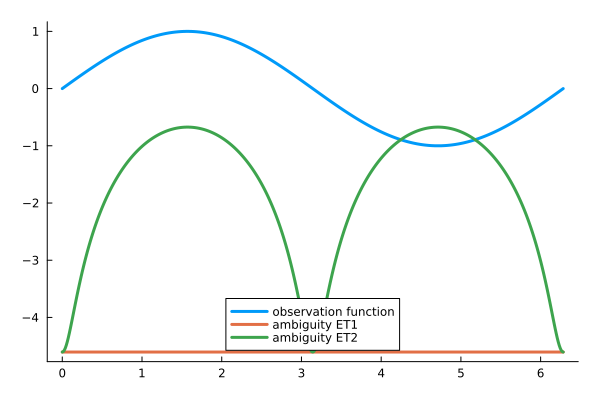

In [7]:
plot(states, g.(states), label="observation function")
plot!(states, ambET1, label="ambiguity ET1", legend=:bottom)
plot!(states, ambET2, label="ambiguity ET2", legend=:bottom)

## 2D states

In [8]:
m = randn(2)
S = diagm(rand(2))

2×2 Matrix{Float64}:
 0.0479106  0.0
 0.0        0.566156

In [9]:
g(x::AbstractVector) = [cos(x[1]), sin(x[2]), tan(x[1]+x[2])]
Jm = ForwardDiff.jacobian(g, m)

3×2 Matrix{Float64}:
 -0.613238  -0.0
  0.0        0.0114674
  2.58263    2.58263

In [10]:
# Dimensionalities
N = length(g(m))
M = length(m)

Jm = ForwardDiff.jacobian(g, m)

3×2 Matrix{Float64}:
 -0.613238  -0.0
  0.0        0.0114674
  2.58263    2.58263

In [45]:
aux1 = zeros(eltype(m), N)
Hi = zeros(eltype(m), M,M,N)
for i in 1:N
    g_i(x) = g(x)[i]
    Hi[:,:,i] = ForwardDiff.hessian(g_i, m)
    aux1 += e(i,N)*tr(Hi[:,:,i]*S)
end
aux1

LoadError: BoundsError: attempt to access 2-element Vector{ForwardDiff.Dual{ForwardDiff.Tag{var"#g_i#28"{Int64}, Float64}, ForwardDiff.Dual{ForwardDiff.Tag{var"#g_i#28"{Int64}, Float64}, Float64, 2}, 2}} at index [3]

In [12]:
# Auxiliary terms
aux2 = zeros(eltype(m), N,N)
for i in 1:N
    for j in 1:N
        aux2 += e(i,N)*e(j,N)'*tr(Hi[:,:,i]*S*Hi[:,:,j]*S)
    end
end
aux2

In [13]:
μ, Σ, Γ = ET2(m,S,g)

([0.7709762790541447, -0.7168748331333052, -3.2531452498032984], [0.018733375216811753 0.0 -0.0699882813531259; 0.0 0.16031971402754033 -1.0245827757638526; -0.0699882813531259 -1.0245827757638526 12.056810641909555], [-0.029380574474487005 0.0 0.12373550377840051; 0.0 0.0064923179172912395 1.4621736507997525])

In [40]:
# Grid over state space
T = 100
ring = range(0, stop=2π, length=T)
states = [cos.(ring'); sin.(1/2 .*ring')]

g(x::AbstractVector) = [sqrt(x[1]^2 + x[2]^2), atan(x[1],x[2])]

# State covariance
S_t = diagm(ones(2))

# Observation noise
R = nothing

ambET2 = zeros(T)    
for k in 1:T

    # Unscented transform moments
    mE, SE, CE = ET2(states[:,k], S_t, g, addmatrix=R)

    # Calculate ambiguity
    ambET2[k] = logdet(SE-CE'*inv(S_t)*CE)
    
end

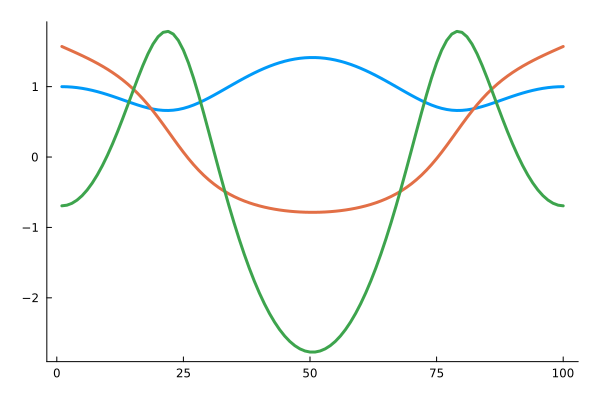

In [44]:
y = cat([g(states[:,i]) for i in 1:T]..., dims=2)
plot(y')
plot!(ambET2)